# 使用冷启动数据微调在新闻语料中预训练的模型，获得初始的自动标注模型

In [1]:
#!AHOCORASICK_BYTES=1 pip install git+https://github.com/WojciechMula/pyahocorasick.git

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random
from tokenizer import tokenizer,token2str,vocab_size
import torch
import torch.nn as nn
from make_model import make_model
from train_and_use import Batch,CrossEntropyLoss,SimpleAdamOptimizer,OptimizerWrapper,train_server_start
from train_and_use import text_continue
from train_and_use import TOGGLE,STOP
from train_and_use import record
from collections import Counter,defaultdict
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# %matplotlib widget

In [3]:
model = make_model(
    #token是从1开始的，0填充，剩下的用来覆盖全部字节
    vocab_size = vocab_size+1+255,
    embedding_dim = 512,
    key_dim = 256,
    head_number = 8,
    position_information_type = "mask",
    # position_information_type = "sinusoidal",
    # position_information_type = "rotary",
    # position_information_type = "learned",
    enable_affine = True,
    enable_talking_head = True,
    use_diff = False,
    self_attention_block_size = 0,
    feed_forward_dim = 1024,
    enable_layer_norm = True,
    deep = 6,
    dropout_rate = 0.1
).to(device)

In [4]:
lines = []
with open('low_init.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：低') for line in f if len(line) > 16]
    lines += random.sample(temp,960)
with open('mid_init.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：中') for line in f if len(line) > 16]
    lines += random.sample(temp,960*2)
with open('high_init.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：高') for line in f if len(line) > 16]
    lines += random.sample(temp,960)

In [5]:
def data_generator(batch_size):
    #将各等级的数据打乱
    np.random.shuffle(lines)
    for i in range(0,len(lines),batch_size):
        data = [tokenizer(line[0],1.0) for line in lines[i:i+batch_size]]
        label = [tokenizer(line[1],5.0) for line in lines[i:i+batch_size]]
        trunk = [(s + [-255]*1000)[:1000]+l for s,l in zip(data,label)]
        trunk = np.array(trunk,dtype=np.int64)+255
        inputs = torch.from_numpy(trunk).to(device).data
        ret = Batch(inputs)
        ret.label = ret.label.clone()
        #只预测最后的标签
        ret.label[:,:-1] = 0
        ret.ntokens = ret.label.size(0)
        yield ret

In [6]:
model.load_state_dict(torch.load('large_model_2.907_.weight',weights_only=True))
model.train()
loss_f = CrossEntropyLoss()
optimizer = OptimizerWrapper(
    optimizer = SimpleAdamOptimizer(model.parameters(),betas = (0.9,0.98),eps = 1e-7),
    warm_up = 200,
    lr = 1e-5
)
split_n    = 48#资源不够时，累积梯度的方式模拟大批次
batch_size = split_n * 2
train_server_start(model,(data_generator,batch_size),split_n,loss_f,optimizer,use_amp = True)

epoch: 27 	step: 0 	loss: 0.854 	speed: 7.00182 tokens/s                     

In [70]:
# TOGGLE()
# STOP()

pause: True


In [8]:
# optimizer.set_lrate(1e-5,480)

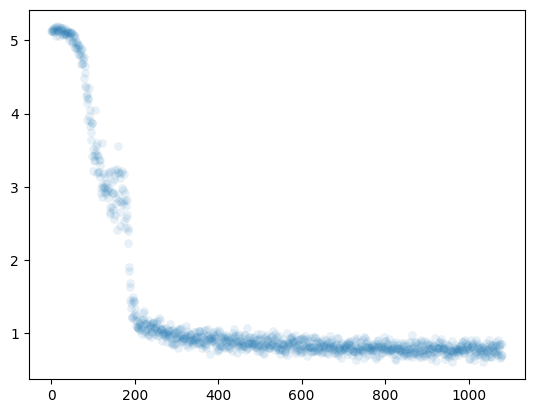

In [71]:
plt.close()
plt.scatter(list(range(len(record['loss_line']))),record['loss_line'],alpha=0.1,linewidths=0.1)
# plt.plot(record['loss_line'])
plt.show()

In [10]:
# plt.close()
# # plt.plot(record['loss_line'])
# plt.plot(record['lr_line'])
# plt.show()

In [28]:
result = []
check = defaultdict(list)
for i in tqdm(range(len(lines))):
    tokens_batch = [(tokenizer(lines[i][0],5.0)+[-255]*1000)[:1000] + tokenizer(lines[i][1],5.0)[:-1]]
    tokens_batch = np.array(tokens_batch,dtype=np.int64)+255
    inputs = torch.from_numpy(tokens_batch).to(device).data
    model = model.eval()
    with torch.no_grad():
        o = text_continue(
            model,inputs,out_length=1,
            repeat_penalty_value = 0.0,
            temperature = 0.01
        )
    res = (lines[i][1][-1],token2str(o[0].cpu().numpy()-255)[-1])
    result += [res]
    check[res[0]+'->'+res[1]] += [i]
    model = model.train()
print(Counter(result))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3840/3840 [06:52<00:00,  9.30it/s]

Counter({('中', '中'): 1521, ('高', '中'): 518, ('低', '中'): 490, ('高', '高'): 429, ('低', '低'): 411, ('中', '高'): 259, ('中', '低'): 140, ('低', '高'): 58, ('高', '低'): 13, ('低', '粗'): 1})


In [64]:
# restype = check['中->低']
# i = restype[np.random.randint(len(restype))]
# lines[i]

('《注定只能是你》是在起点中文网连载的一部小说，作者是林小猫。 休闲美文。休闲美文 出生那天,我还在娘胎里挣扎着出去,总觉得有人在踩我的头,然后听到了一声哭声,靠,有没有搞错,踩我的头,你哭得比我还大声啊！不行,怎么能让你比下去,哼,我哭！哭得比你大声"哎呀！怎么还有一个啊"护士惊叫起来,赶紧叫另一个护士抱着我"是龙凤胎呢！两小家伙肺活量很不错啊,声音这么洪亮"从出生那天就注定了要被这个踩我头的人吃定了,他是葵',
 ' 这段文本的质量按照“高、中、低”三档评价为：中')

In [73]:
# torch.save(model.state_dict(),'autotagger_init.weight')